In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from pathlib import Path
from ruamel import yaml
from pprint import pprint

from ipywidgets import interact

import h5py

In [3]:
from lib_lt.tools import recursive_read_attrs
from lib_lt import tracker

/home/carmelo/lense_thirring/lib_lt/tracker.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
%matplotlib inline

In [5]:
!ls /home/carmelo/lense_thirring/code/bh3/run

0000  0003  0006  0009	0012  0015  0018  0021	0024  0027  0030  0033
0001  0004  0007  0010	0013  0016  0019  0022	0025  0028  0031  0034
0002  0005  0008  0011	0014  0017  0020  0023	0026  0029  0032  0035


In [6]:
root = Path('/home/carmelo/lense_thirring/code/bh3')

# h5filename = root / 'run/0026/bh_0002.h5'
# h5filename = root / 'run/0034/bh_0000.h5'
h5filename = root / 'run/0030/bh_0000.h5'  # (500, 10), --



conf = recursive_read_attrs(h5filename, 'configure')
print(conf['globals']['Gamma'], conf['globals']['nu'])

500 10


In [7]:
home_group = 'realtime'

with h5py.File(h5filename, 'r') as f:
    g = f[f'{home_group}/1']
#     g = f['imprint_pair/1']
    t = g['t'][:]
    x = g['x'][:]
    y = g['y'][:]
    psiI = g['psiI'][:]
    psiR = g['psiR'][:]

n = psiI**2 + psiR**2
phase = np.arctan2(psiI, psiR)

N = np.sum(n, axis=(1, 2))

X, Y = np.meshgrid(x, y, indexing='ij')
R = np.hypot(X, Y)
phi = np.arctan2(Y, X)

# omega[R < 15] = 0

print(len(t), t[-1])

800 100.0000000261416


## Test tracking

In [8]:
%matplotlib inline

3


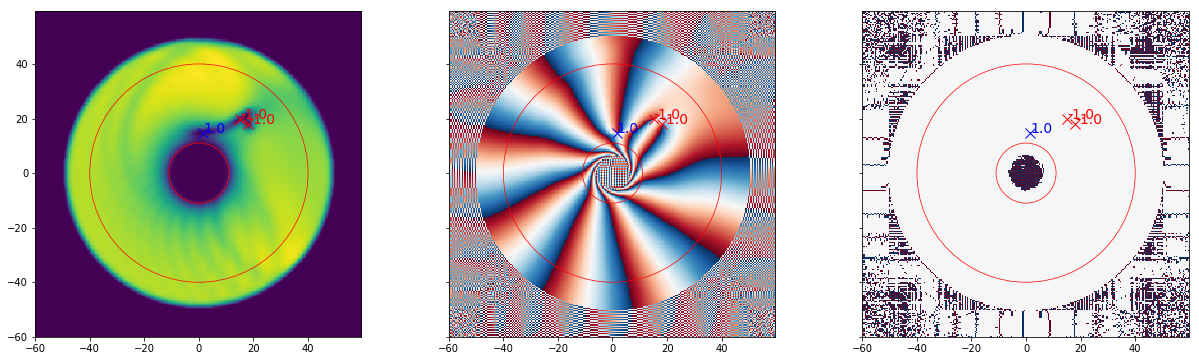

In [10]:
# test one single tracking

ix = 221
# ix = 10

def _imshow(ax, X, *args, **kwargs):
    return ax.imshow(np.rot90(X), extent=(x.min(), x.max(), y.min(), y.max()), *args, **kwargs)
#     return ax.imshow(X, extent=(y.min(), y.max(), x.max(), x.min()), *args, **kwargs)
#     return ax.matshow(X, extent=(y.min(), y.max(), x.max(), x.min()), *args, **kwargs)


fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharex=True, sharey=True)
ax_n, ax_p, ax = axes.ravel()


_imshow(ax_n, n[ix])
_imshow(ax_p, phase[ix], cmap='RdBu', vmin=-np.pi, vmax=np.pi)


ph = phase[ix]

# vx, vy = np.gradient(ph)
# rot = np.gradient(vy, axis=0) - np.gradient(vx, axis=1)

omega = tracker.phase_winding2d(ph)

_imshow(ax, np.round(omega), cmap='RdBu', vmin=-1, vmax=1)


# indices = peak_local_max(im, threshold_rel=0.25, threshold_abs=0.1)

rmin, rmax = 11, 40
indices, coords, vorticity = tracker.vortex_detect2d(x, y, psiR[ix], psiI[ix], cutoff_radii=(rmin, rmax))
print(len(coords))
for j, (mx, my) in enumerate(coords):
    mx, my = coords[j]
    v = np.round(vorticity[j])
    for _ax in axes:
        l, = _ax.plot(mx, my, 'x', color='b' if v > 0 else 'r', ms=10, mfc='none')
        _ax.text(mx, my, v, color=l.get_color(), fontsize=14)

    
for _ax in axes:
    _ax.add_patch(Circle((0, 0), rmin, fc='none', ec='r', lw=0.7))
    _ax.add_patch(Circle((0, 0), rmax, fc='none', ec='r', lw=0.7))

    


In [11]:
%matplotlib notebook

In [12]:
# labeling

from tqdm.notebook import tqdm

coords = []
vorticity = []

rmin, rmax = 11, 40
for ix in tqdm(range(len(t))):
    indices, _coords, _vorticity = tracker.vortex_detect2d(x, y, psiR[ix], psiI[ix], cutoff_radii=(rmin, rmax))
    coords.append(_coords)
    vorticity.append(_vorticity)

In [13]:
import uuid

class Vortex:
    def __init__(self, t, x, y, sign):
        self.t = t
        self.x = x
        self.y = y
        self.sign = sign
        self.label = None
    
    def dist(self, other):
        return np.hypot(self.x - other.x, self.y - other.y)
    
class Trajectory:
    def __init__(self, vlist):
        self.t = self._unravel('t', vlist)
        ix = np.argsort(self.t)
        self.t = self.t[ix]
        self.x = self._unravel('x', vlist)[ix]
        self.y = self._unravel('y', vlist)[ix]
        self.sign = self._unravel('sign', vlist)[ix]
    
    def _unravel(self, attr, vlist):
        return np.asarray([getattr(v, attr) for v in vlist])
    
    def __len__(self):
        return len(self.t)
    
vortices = []
for j in range(len(t)):
    time = t[j]
    vts = []
    for (vx, vy), sign in zip(coords[j], vorticity[j]):
        vts.append(Vortex(time, vx, vy, sign))
    vortices.append(vts)

for v in vortices[0]:
    v.label = uuid.uuid4().hex

d_threshold = 0.4

for j in range(1, len(t)):
    for new_v in vortices[j]:
        for old_v in vortices[j - 1]:
            d = new_v.dist(old_v)
            if d < d_threshold:
                new_v.label = old_v.label
                break
        if new_v.label is None:
            new_v.label = uuid.uuid4().hex
            
labels = {v.label for vs in vortices for v in vs}
vortices = [
    Trajectory([v for vs in vortices for v in vs if v.label == l])
    for l in labels
]

vortices = list(sorted(vortices, key=lambda vx: len(vx), reverse=True))



In [14]:
sum(len(v) for v in vortices)

2423

In [18]:
%matplotlib notebook

<IPython.core.display.Javascript object>


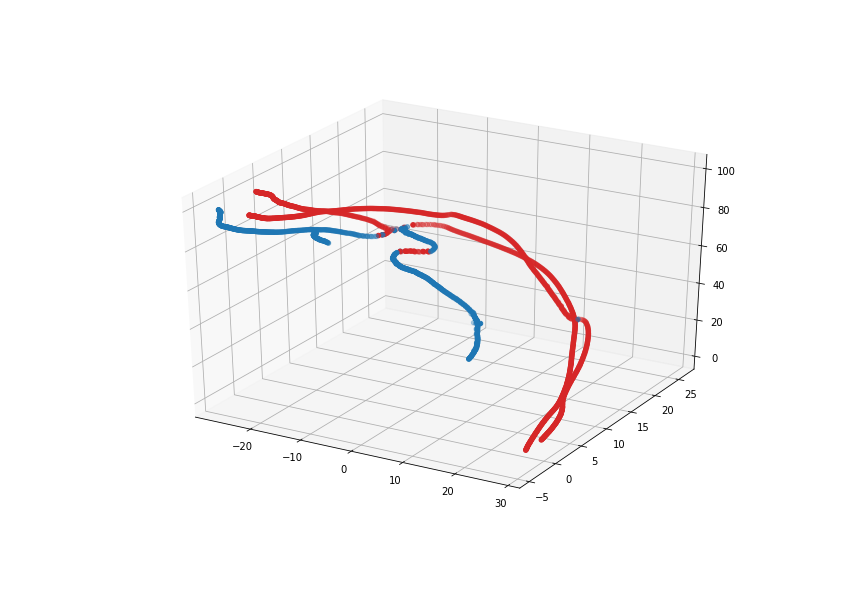

In [22]:
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for v in vortices:
    _x, _y = v.x, v.y
    _t = v.t
    col = np.where(v.sign > 0, 'C0', 'C3')
    ax.scatter(_x, _y, _t, c=col)

In [267]:
v['coords'].shape

(1, 2)

In [187]:
nvortices = [len(c) for c in coords]

In [188]:
plt.plot(t, nvortices)

In [91]:
coords[0]

array([[27.8969733 , -1.39034923],
       [27.92114237,  1.54053614]])

In [92]:
np.round(vorticity[2])

array([-1, -1])

In [32]:
vorticity.shape

(3, 2, 255)

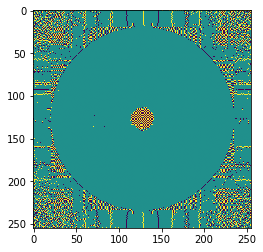

In [10]:
plt.imshow(np.rot90(rot))

In [28]:
coords

array([[-16.21428362,  15.74175996],
       [ -5.26546459,   6.25598052],
       [ -5.27977804,   6.32085738],
       [ -5.07751022,   6.10303561]])

## Track and analyse

In [28]:
1, 2, 4, 5, 7, 8, 9

(1, 2, 4, 5, 7, 8, 9)